<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/pixels_seg_ML_save_trained_model_1_multi_CLFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## source: DigitalSreeni 
from skimage.io import imread, imshow
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time

#img = cv2.imread('BSE_Image.jpg')
img = cv2.imread('/content/001_cropped.JPG')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 
#Multiple images can be used for training. For that, you need to concatenate the data

#Save original image pixels into a data frame. This is our Feature #1.
img2 = img.reshape(-1)
df = pd.DataFrame()

t0 = time.time()   ## starting time

df['Original Image'] = img2

#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
########################################
#Gerate OTHER FEATURES out of pixels and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe

feat_ext_time = time.time()-t0
local_time_feature_rxtraction = time.localtime(feat_ext_time)
###########################               

#Now, add a column in the data frame for the Labels
#For this, we need to import the labeled image
# labeled_img = cv2.imread('/content/Sandstone_Versa0000(mask).tif')  # if we use saved mask
 ########################## if we do not use ready saved mask
ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY) ## I will assume our mask is the binary image
#imshow(binary.reshape(img.shape))

plt.imshow(binary, cmap ='jet')
labeled_img =binary
############################
#Remember that you can load an image with partial labels 
#But, drop the rows with unlabeled data

#labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY) # if we use mask
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

print('the unique labels', df['Labels'].unique())
print('the count of the unique labels', df['Labels'].value_counts())
# df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
print(df.head())

df.to_csv("pixels_features_and_lables.csv")
#############################
#Define the dependent variable that needs to be predicted (labels)
Y = df["Labels"].values

#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)
############################### list of classifieres:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

##https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# names = ["Nearest Neighbors", "Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes", "QDA"]
# ##,"Gaussian Process"
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
#     SVC(gamma=2, C=1, max_iter=100, random_state=42),
#     #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
#     DecisionTreeClassifier(max_depth=5, random_state = 42),
#     RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
#     MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]
## , random_state=42


names = ["Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes", "QDA"]
##,"Gaussian Process"
classifiers = [
    SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
    SVC(gamma=2, C=1, max_iter=100, random_state=42),
    #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
    DecisionTreeClassifier(max_depth=5, random_state = 42),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
    MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

############################### 
# Import the model we are using RandomForestRegressor 

start_train_time = time.time()
for name, model in zip(names, classifiers):
  print('name', name)
  # Train the model on training data
  model.fit(X_train, y_train)
  train_time = time.time()-start_train_time
  local_train_time = time.localtime(train_time)

  # verify number of trees used. If not defined above. 
  #print('Number of Trees used : ', model.n_estimators)

  #STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA AND CALCULATE THE ACCURACY SCORE
  #First test prediction on the training data itself. SHould be good. 
  prediction_test_train = model.predict(X_train)
  start_test_time = time.time()-train_time

  #Test prediction on testing data. 
  prediction_test = model.predict(X_test)

  test_time = time.time()-start_test_time
  local_test_time = time.localtime(test_time)
  print(name, ' CLF: Feature extraction time = H:M:S', local_time_feature_rxtraction.tm_hour,':',local_time_feature_rxtraction.tm_min,':',local_time_feature_rxtraction.tm_sec)
  print(name, ' CLF: Train time = H:M:S', local_train_time.tm_hour,':',local_train_time.tm_min,':',local_train_time.tm_sec)
  print(name, ' CLF: Test time = H:M:S', local_test_time.tm_hour,':',local_test_time.tm_min,':',local_test_time.tm_sec)
  total_time = feat_ext_time+train_time+test_time
  total_time = time.localtime(total_time)
  print(name, ' CLF: Total time = H:M:S', total_time.tm_hour,':',total_time.tm_min,':',total_time.tm_sec)

  #.predict just takes the .predict_proba output and changes everything to 0 below a certain threshold (usually 0.5) respectively to 1 above that threshold.
  #In this example we have 2 labels, so the probabilities will for each label stored separately. 

  #prediction_prob_test = model.predict_proba(X_test)

  #Let us check the accuracy on test data
  from sklearn import metrics
  #Print the prediction accuracy

  #First check the accuracy on training data. This will be higher than test data prediction accuracy.
  train_acc = metrics.accuracy_score(y_train, prediction_test_train)*100
  print ("Accuracy on training data = ", round(train_acc,3), '%')
  #Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
  test_acc = metrics.accuracy_score(y_test, prediction_test)*100
  print ("Accuracy on testing data = ", round(test_acc,3), '%')

  #This part commented out for SVM testing. Uncomment for random forest. 
  #One amazing feature of Random forest is that it provides us info on feature importances
  # Get numerical feature importances importances = list(model.feature_importances_)

  # feature_list = list(X.columns)
  # feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
  # print('The scors or important features',feature_imp)
  # feature_imp.to_csv("important_features.csv")

  #You can store the model for future use. In fact, this is how you do machine elarning
  #Train on training images, validate on test images and deploy the model on unknown images. 

  import pickle

  #Save the trained model as pickle string to disk for future use
  filename = "/content/CLF_res/{}_trained_model".format(name)

  pickle.dump(model, open(filename, 'wb'))

  #To test the model on future datasets
  loaded_model = pickle.load(open(filename, 'rb'))
  result = loaded_model.predict(X)

  segmented = result.reshape((img.shape))

  plt.imshow(segmented, cmap ='jet')
  plt.imsave('/content/CLF_res/predicted_image_{}.jpg'.format(name), segmented, cmap ='jet')

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear SVM  CLF: Feature extraction time = H:M:S 0 : 0 : 44
Linear SVM  CLF: Train time = H:M:S 0 : 0 : 11
Linear SVM  CLF: Test time = H:M:S 0 : 0 : 17
Linear SVM  CLF: Total time = H:M:S 0 : 1 : 12
Accuracy on training data =  99.919 %
Accuracy on testing data =  99.923 %
name RBF SVM


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
from google.colab import files
!zip -r /content/CLF_res.zip /content/CLF_res
files.download('/content/CLF_res.zip')

  adding: content/CLF_res/ (stored 0%)
  adding: content/CLF_res/predicted_image_Neural Net.jpg (deflated 19%)
  adding: content/CLF_res/AdaBoost_trained_model (deflated 62%)
  adding: content/CLF_res/Decision Tree_trained_model (deflated 51%)
  adding: content/CLF_res/predicted_image_Decision Tree.jpg (deflated 18%)
  adding: content/CLF_res/predicted_image_RBF SVM.jpg (deflated 38%)
  adding: content/CLF_res/predicted_image_Naive Bayes.jpg (deflated 19%)
  adding: content/CLF_res/predicted_image_Random Forest.jpg (deflated 19%)
  adding: content/CLF_res/Random Forest_trained_model (deflated 70%)
  adding: content/CLF_res/predicted_image_QDA.jpg (deflated 19%)
  adding: content/CLF_res/predicted_image_AdaBoost.jpg (deflated 18%)
  adding: content/CLF_res/Naive Bayes_trained_model (deflated 38%)
  adding: content/CLF_res/Neural Net_trained_model (deflated 4%)
  adding: content/CLF_res/QDA_trained_model (deflated 33%)
  adding: content/CLF_res/RBF SVM_trained_model (deflated 83%)
  addi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##rm -rf '/content/CLF_res' ## dengarous will delete all the folder 

# **New test to use 3 labels of shapes instaed of binary**

orginal image
img.shape (1080, 1300, 3)


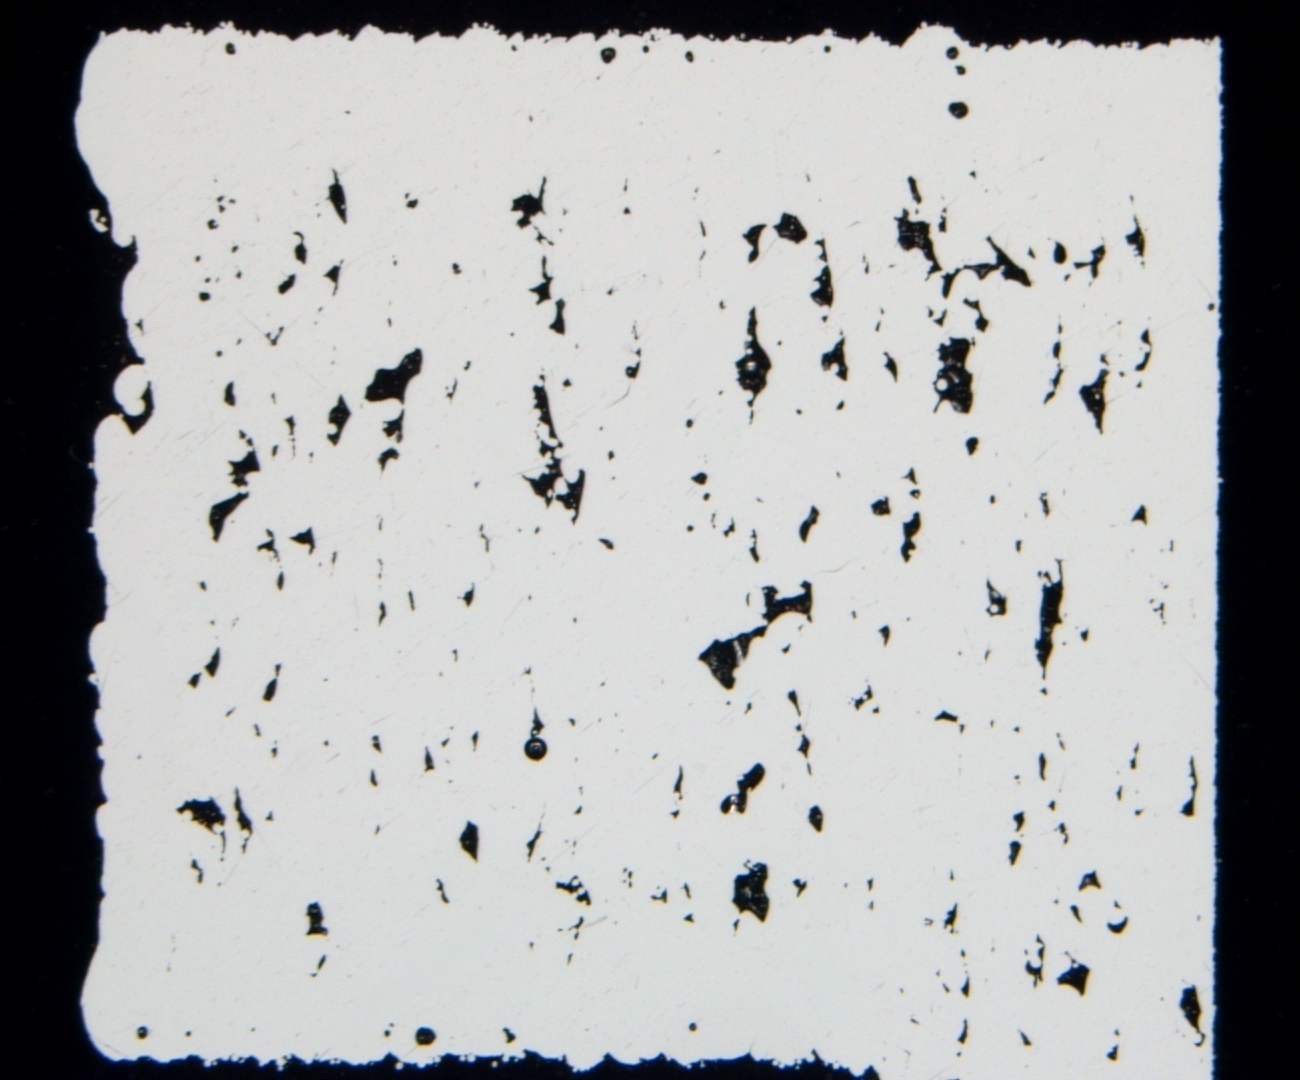

gray image
gray image.shape (1080, 1300)


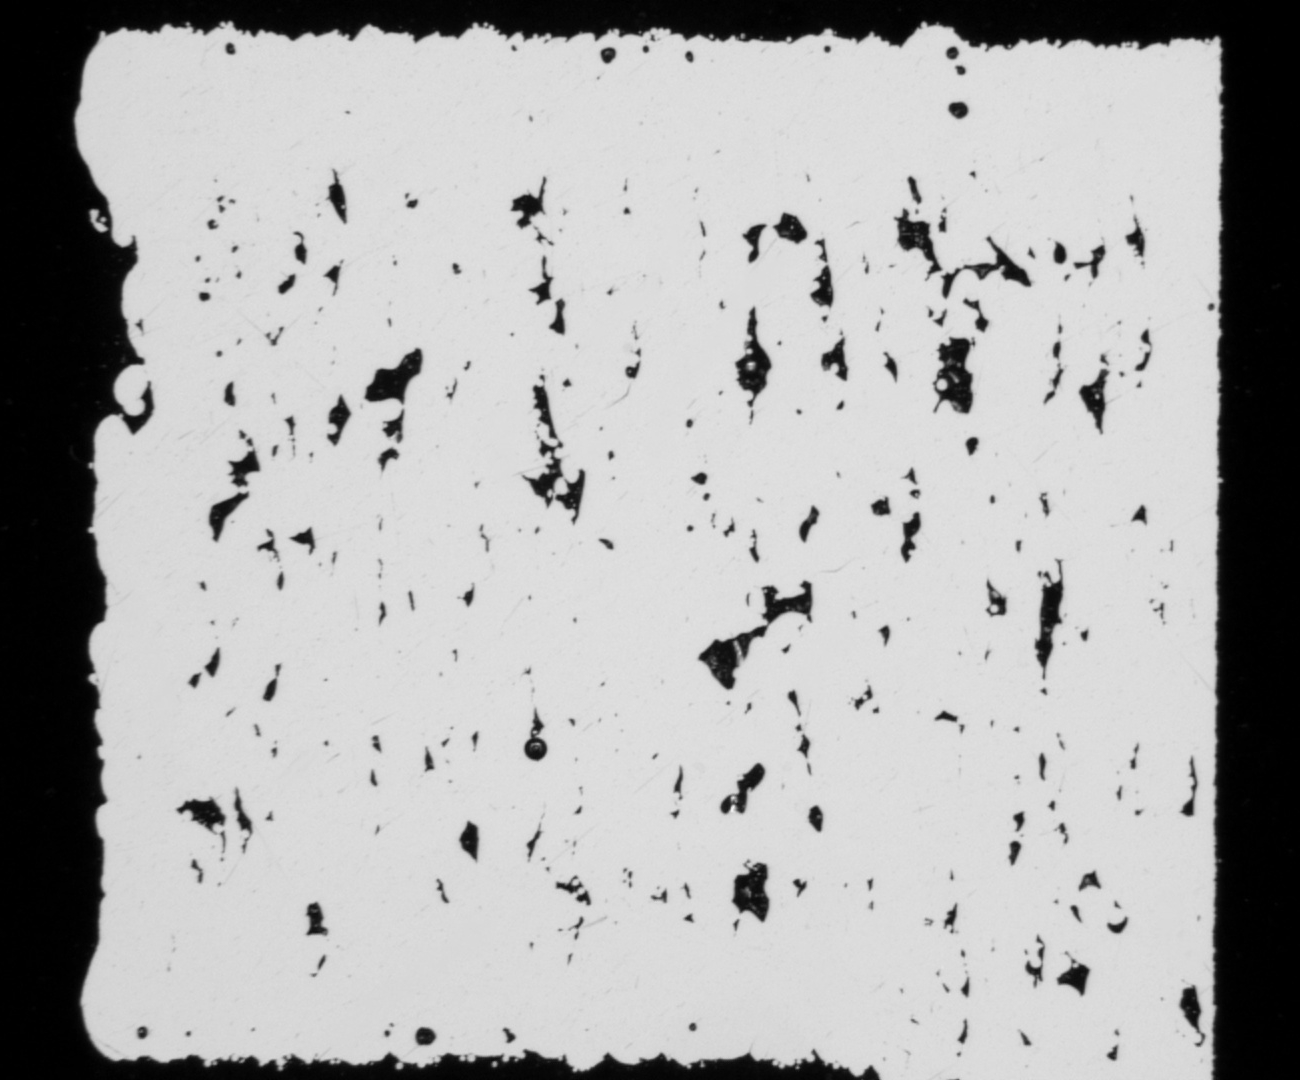

In [1]:
## source: DigitalSreeni 
from skimage.io import imread, imshow
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import time
from google.colab.patches import cv2_imshow

#img = cv2.imread('BSE_Image.jpg')
img_org = cv2.imread('/content/001.JPG')
img_org = img_org[:, 300:1600]  ## croped image
print('orginal image')
print('img.shape',img_org.shape)
cv2_imshow(img_org)

img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY) 
print('gray image')
print('gray image.shape',img.shape)
cv2_imshow(img)
# imshow(img_org)
# imshow(img)

# Extract pixel features

In [2]:
#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 
#Multiple images can be used for training. For that, you need to concatenate the data
#Save original image pixels into a data frame. This is our Feature #1.

img2 = img.reshape(-1) ## reshape the image into single column
print('img2.shape',img2.shape)
df = pd.DataFrame()
t0 = time.time()   ## starting time

df['Original Image'] = img2

#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []
for theta in range(2):   #Define number of thetas
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
            
                
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
########################################
#Gerate OTHER FEATURES out of pixels and add them to the data frame
                
#CANNY EDGE
edges = cv2.Canny(img, 100,200)   #Image, min and max values
edges1 = edges.reshape(-1)
df['Canny Edge'] = edges1 #Add column to original dataframe

from skimage.filters import roberts, sobel, scharr, prewitt

#ROBERTS EDGE
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

#SOBEL
edge_sobel = sobel(img)
edge_sobel1 = edge_sobel.reshape(-1)
df['Sobel'] = edge_sobel1

#SCHARR
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

#PREWITT
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#GAUSSIAN with sigma=3
from scipy import ndimage as nd
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian_img1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian_img1

#GAUSSIAN with sigma=7
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian_img3 = gaussian_img2.reshape(-1)
df['Gaussian s7'] = gaussian_img3

#MEDIAN with sigma=3
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

#VARIANCE with size=3
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1  #Add column to original dataframe

feat_ext_time = time.time()-t0
local_time_feature_rxtraction = time.localtime(feat_ext_time)

img2.shape (1404000,)
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0

img.shape (1080, 1300)
img2.shape (1404000,)


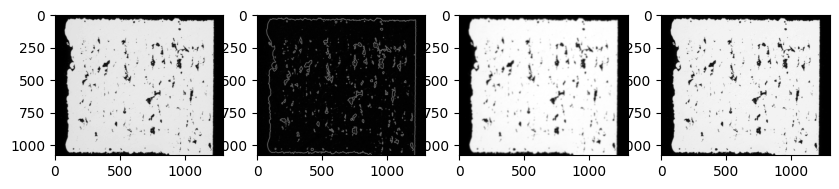

In [3]:
# show some pf the feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(10,10))
print('img.shape',img.shape)
print('img2.shape',img2.shape)

axes[0].imshow(np.asanyarray(df['Original Image']).reshape(img.shape), cmap=plt.cm.gray)
axes[1].imshow(np.asanyarray(df['Sobel']).reshape(img.shape), cmap=plt.cm.gray)
axes[2].imshow(np.asanyarray(df['Gaussian s3']).reshape(img.shape), cmap=plt.cm.gray)
axes[3].imshow(np.asanyarray(df['Median s3']).reshape(img.shape), cmap=plt.cm.gray)


# output (pore shapes) labels and create a mask

the binary image
binary shape (1080, 1300)


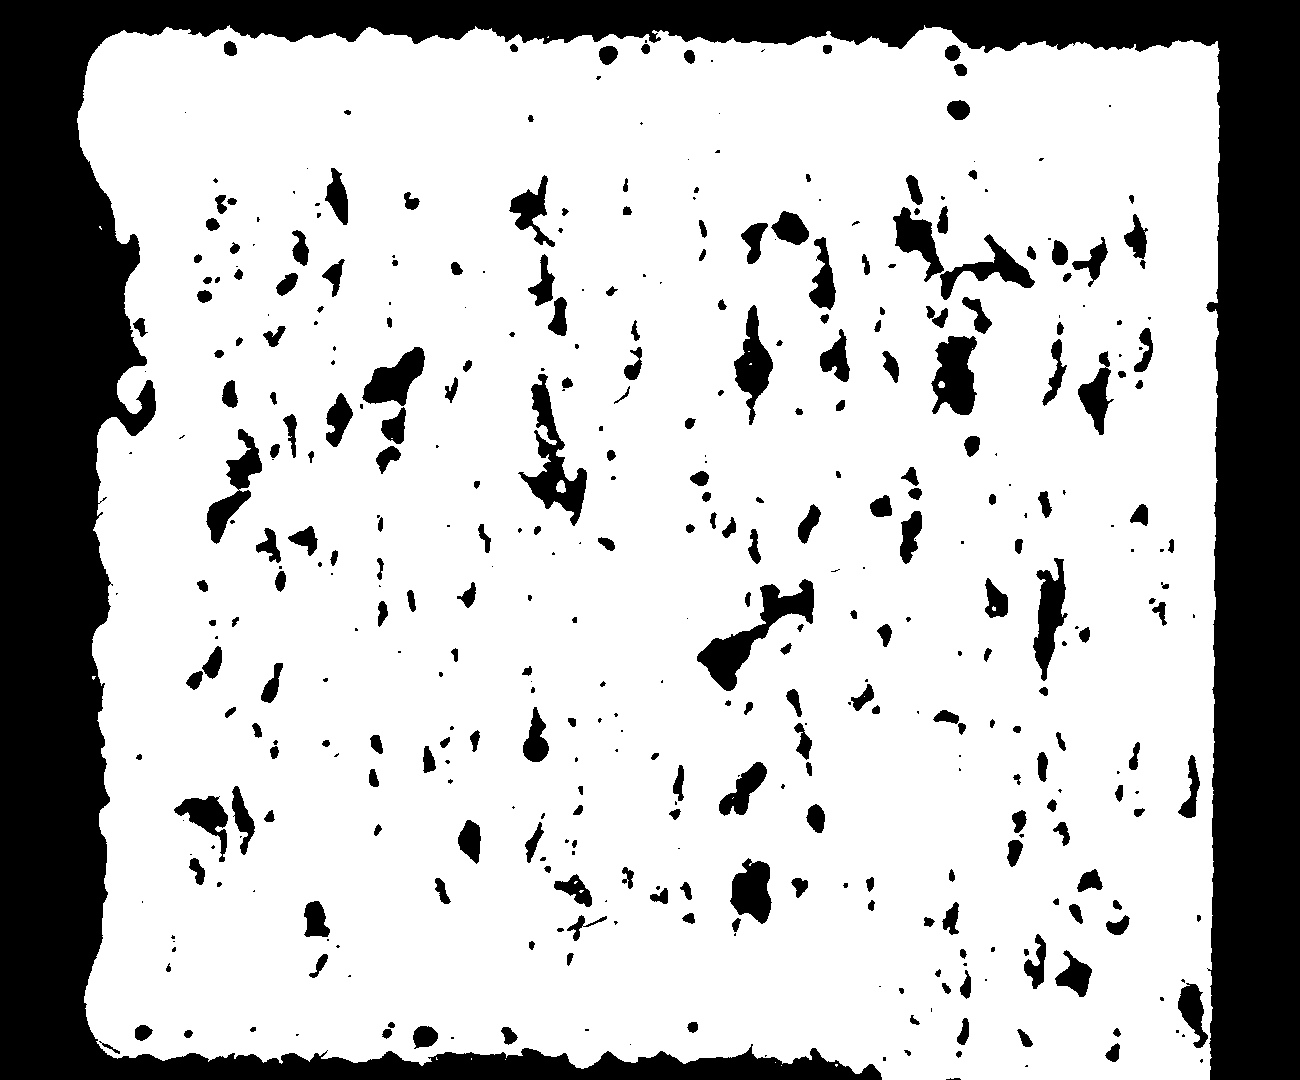

len main contours 459
the annotated image
annotated_img shape (1080, 1300, 3)


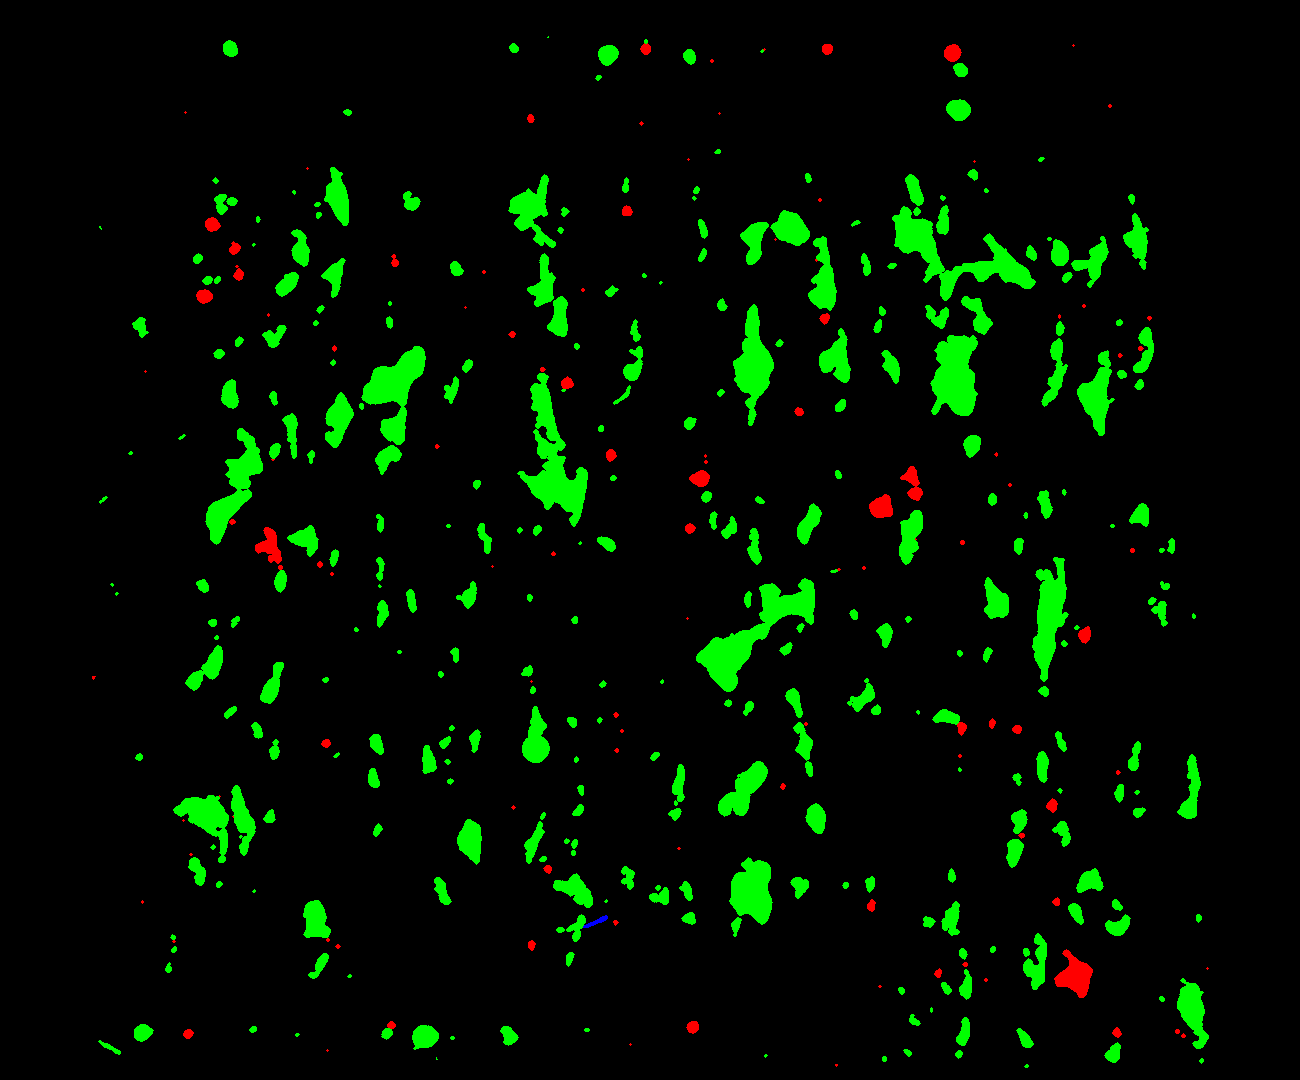

labeled_img1 shape (1404000,)
annotation shape (1080, 1300)
the unique labels [0 3 2 1]
the count of the unique labels 0    1312503
3      85026
2       6358
1        113
Name: Labels, dtype: int64
labeled_img1 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [4]:
# Threshold the image to obtain binary image
ret, binary = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)   ## check from here
# Find contours in the binary image
print('the binary image')
print('binary shape', binary.shape)
cv2_imshow(binary)
# plt.imshow(binary)
# plt.show()
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print('len main contours', len(contours))
max_cnt = max(contours, key = cv2.contourArea)

# Create an empty binary mask for each contour
masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]
#print("masks", masks)

# Loop through each contour
for i, cnt in enumerate(contours):
    rect = cv2.minAreaRect(cnt)
    area = cv2.contourArea(cnt)
    # max_cnt = max(contours, key=cv2.contourArea)
    max_area = cv2.contourArea(max_cnt)
    if area != max_area and area != 0: # if the current contour area is not equal to workpiece area 
        (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
        aspect_ratio = max(w, h) / min(w, h)
        #print("aspect ratio", aspect_ratio)
        # Get the shape of the contour
        if aspect_ratio >= 5:
            annotation = 1 # (1) Label as a line
            #cv2.drawContours(img, [cnt], 0, (255, 0, 0), 2)  # Blue for lines
        elif aspect_ratio > 1.1 and aspect_ratio < 5:
            annotation = 3 # (3) Label as an ellipse 
            #cv2.drawContours(img, [cnt], 0, (0, 255, 0), 2)  # Green for ellipses
        else:
            annotation = 2 # (2) Label as a circle
            #cv2.drawContours(img, [cnt], 0, (0, 0, 255), 2)  # red for circles
        # Fill the mask with the annotation value
        cv2.drawContours(masks[i], [cnt], 0, annotation, -1)

# Combine all masks to create the final annotation image
annotation = np.zeros(binary.shape, dtype=np.uint8)
for mask in masks:
  annotation[mask > 0] = mask[mask > 0]

# Color the pixels belonging to each contour
colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
annotated_img = np.zeros_like(img_org)

#annotated_img[pix_line[0][0], pix_line[0][1]] = np.array([255, 0, 0])
for annotation_value, color in colors.items():
  pixels_of_certain_type = np.argwhere(annotation == annotation_value)
  for x,y in pixels_of_certain_type:
    annotated_img[x, y] = np.array(color)


# Show the final annotated image
print('the annotated image')
print('annotated_img shape', annotated_img.shape)
cv2_imshow(annotated_img)
# plt.imshow(annotated_img)
# plt.show()

labeled_img1 = annotation.reshape(-1) ### here is the change
print('labeled_img1 shape', labeled_img1.shape)
print('annotation shape', annotation.shape)
df['Labels'] = labeled_img1
#####################################
print('the unique labels', df['Labels'].unique())
print('the count of the unique labels', df['Labels'].value_counts())

print("labeled_img1", labeled_img1[88600:88829])
df.to_csv("before_removing_pixels_pixels_features_and_lables.csv")

#df = df[df['Labels'] != 0] ## to remove the pixels of the background which not represensetive to our objects
###print(df.head())
df.to_csv("pixels_features_and_lables.csv")

# Define the dependent variable that needs to be predicted (labels) and split into train and test

In [5]:
Y = df["Labels"].values
#Define the independent variables
X = df.drop(labels = ["Labels"], axis=1) 

#Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=20)

# import the classifiers

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

##https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# names = ["Nearest Neighbors", "Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes", "QDA"]
# ##,"Gaussian Process"
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
#     SVC(gamma=2, C=1, max_iter=100, random_state=42),
#     #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
#     DecisionTreeClassifier(max_depth=5, random_state = 42),
#     RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
#     MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]
## , random_state=42

# names = ["Linear SVM","RBF SVM","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes"]
# ##,"Gaussian Process"
# classifiers = [
#     SVC(kernel="linear", C=0.025, max_iter=100, random_state=42),
#     SVC(gamma=2, C=1, max_iter=100, random_state=42),
#     #GaussianProcessClassifier(1.0 * RBF(1.0),random_state = 42),
#     DecisionTreeClassifier(max_depth=5, random_state = 42),
#     RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42),
#     MLPClassifier(alpha=1, max_iter=1000, random_state = 42),
#     AdaBoostClassifier(),
#     GaussianNB(),
# ]

names = ["Random Forest"]
##,"Gaussian Process"
classifiers = [
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state = 42)
]

In [7]:
start_train_time = time.time()
for name, model in zip(names, classifiers):
  print('name', name)
  # Train the model on training data
  model.fit(X_train, y_train)
  train_time = time.time()-start_train_time
  local_train_time = time.localtime(train_time)

  # verify number of trees used. If not defined above. 
  #print('Number of Trees used : ', model.n_estimators)

  #STEP 8: TESTING THE MODEL BY PREDICTING ON TEST DATA AND CALCULATE THE ACCURACY SCORE
  #First test prediction on the training data itself. SHould be good. 
  prediction_train = model.predict(X_train)
  start_test_time = time.time()-train_time
  print("prediction_train results", prediction_train[:250])

  #Test prediction on testing data. 
  prediction_test = model.predict(X_test)
  print("prediction_test results", prediction_test[:250])
  print('X_train.shape',X_train.shape)
  print('X_test.shape',X_test.shape)
  print('prediction_train.shape',prediction_train.shape)
  print('prediction_test.shape',prediction_test.shape)
  print('img.shape',img.shape)
  concat_train_test = np.concatenate((prediction_train, prediction_test), axis=0)
  print('concat_train_test',concat_train_test.shape)
  print('type of prediction_train', type(prediction_train))
  # plt.imshow(concat_train_test.reshape(img.shape))
  # cv2_imshow(concat_train_test.reshape(img.shape))
  ##plt.imshow(concat_train_test.reshape(img.shape), vmin=0, vmax=2)

  test_time = time.time()-start_test_time
  local_test_time = time.localtime(test_time)
  print(name, ' CLF: Feature extraction time = H:M:S', local_time_feature_rxtraction.tm_hour,':',local_time_feature_rxtraction.tm_min,':',local_time_feature_rxtraction.tm_sec)
  print(name, ' CLF: Train time = H:M:S', local_train_time.tm_hour,':',local_train_time.tm_min,':',local_train_time.tm_sec)
  print(name, ' CLF: Test time = H:M:S', local_test_time.tm_hour,':',local_test_time.tm_min,':',local_test_time.tm_sec)
  total_time = feat_ext_time+train_time+test_time
  total_time = time.localtime(total_time)
  print(name, ' CLF: Total time = H:M:S', total_time.tm_hour,':',total_time.tm_min,':',total_time.tm_sec)

  #.predict just takes the .predict_proba output and changes everything to 0 below a certain threshold (usually 0.5) respectively to 1 above that threshold.
  #In this example we have 2 labels, so the probabilities will for each label stored separately. 

  #prediction_prob_test = model.predict_proba(X_test)

  #Let us check the accuracy on test data
  from sklearn import metrics

  #First check the accuracy on training data. This will be higher than test data prediction accuracy.
  train_acc = metrics.accuracy_score(y_train, prediction_train)*100
  print ("Accuracy on training data = ", round(train_acc,3), '%')
  #Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
  test_acc = metrics.accuracy_score(y_test, prediction_test)*100
  print ("Accuracy on testing data = ", round(test_acc,3), '%')

  #This part commented out for SVM testing. Uncomment for random forest. 
  #One amazing feature of Random forest is that it provides us info on feature importances
  #Get numerical feature importances importances = list(model.feature_importances_)

  # feature_list = list(X.columns)
  # feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
  # print('The scors or important features',feature_imp)
  # feature_imp.to_csv("important_features.csv")

  #Store the model for future use. In fact, this is how you do machine elarning
  #Train on training images, validate on test images and deploy the model on unknown images. 

  import pickle
  #Save the trained model as pickle string to disk for future use
  filename = "/content/CLF_res/{}_trained_model".format(name)
  pickle.dump(model, open(filename, 'wb'))





name Random Forest
prediction_train results [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
prediction_test results [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 3 0 0 0
 0 3 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3 3 0 0 3 0 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 0 0 

# **predict using new images with the saved model**

Accuracy on full image data =  97.051 %
unique predicted labels [0 3]


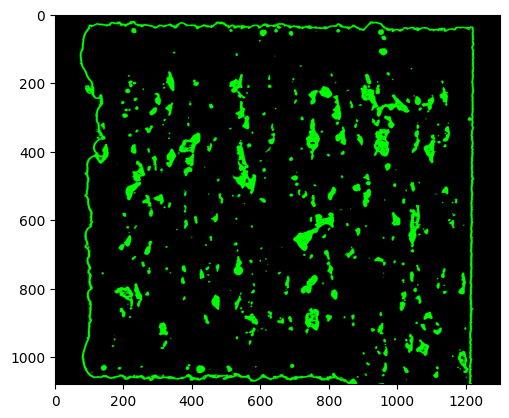

In [8]:
 # extract X from the new image
 
  #To test the model on future datasets
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X)

acc = metrics.accuracy_score(Y, result)*100
print ("Accuracy on full image data = ", round(acc,3), '%')
print("unique predicted labels", np.unique(result))

segmented = result.reshape((img.shape))

predicted_img = np.zeros_like(img_org)

for annotation_value, color in colors.items():
  pixels_of_certain_type = np.argwhere(segmented == annotation_value)
  for x,y in pixels_of_certain_type:
    predicted_img[x, y] = np.array(color)


plt.imshow(predicted_img)
plt.imsave('/content/CLF_res/predicted_image_{}.jpg'.format(name), predicted_img)

# Create a mask to be used as labels (target: three shaps L,C,E)

the orginal image
orginal image shape (475, 548, 3)


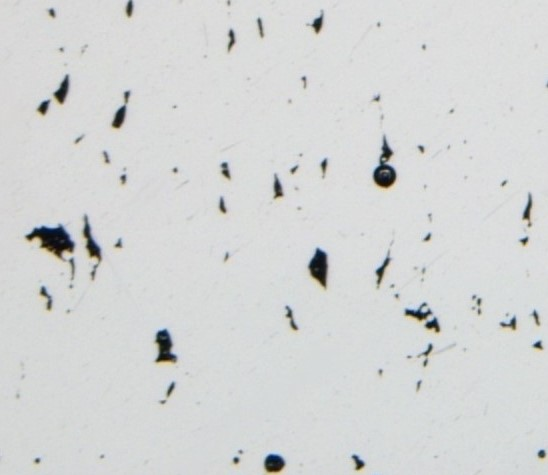

the gray image
gray shape (475, 548)


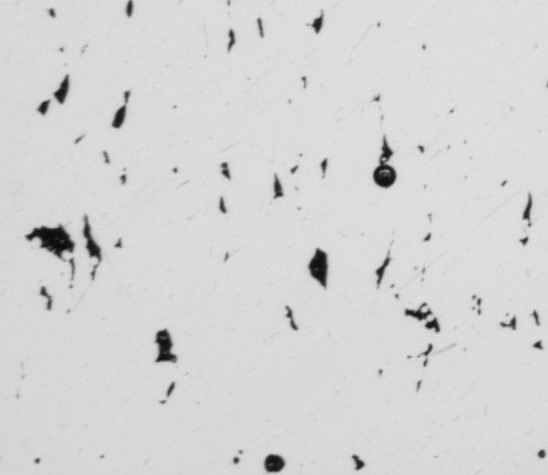

the binary image
binary shape (475, 548)


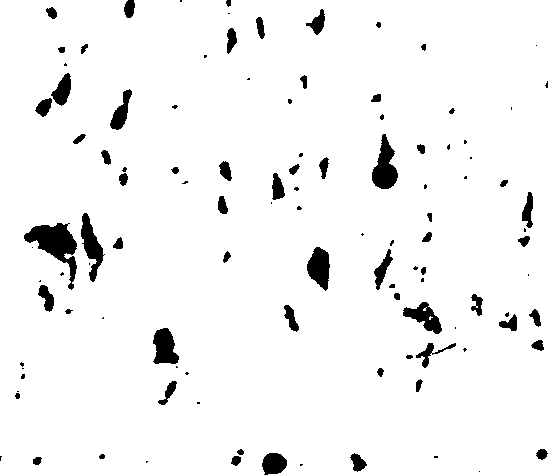

len main contours 110
the annotated image
annotated_img shape (475, 548, 3)


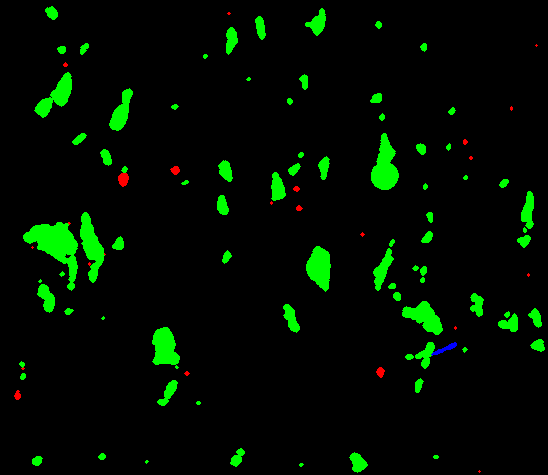

labeled_img1 shape (780900,)
the unique labels [  0 255]
the count of the unique labels 0      766314
255     14586
Name: Labels, dtype: int64
labeled_img1 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [ ]:
## create a mask with aspect ratio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow

# Load the image and convert it to grayscale
img = cv2.imread('/content/001_cropped - Kopie.JPG')
print('the orginal image')
print('orginal image shape', img.shape)
cv2_imshow(img)
# plt.imshow(img)
# plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('the gray image')
print('gray shape', gray.shape)
cv2_imshow(gray)
# plt.imshow(gray)
# plt.show()

# Threshold the image to obtain binary image
ret, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)   ## check from here
# Find contours in the binary image
print('the binary image')
print('binary shape', binary.shape)
cv2_imshow(binary)
# plt.imshow(binary)
# plt.show()
contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print('len main contours', len(contours))
max_cnt = max(contours, key = cv2.contourArea)

# Create an empty binary mask for each contour
masks = [np.zeros(binary.shape, dtype=np.uint8) for _ in contours]
#print("masks", masks)

# Loop through each contour
for i, cnt in enumerate(contours):
    rect = cv2.minAreaRect(cnt)
    area = cv2.contourArea(cnt)
    # max_cnt = max(contours, key=cv2.contourArea)
    max_area = cv2.contourArea(max_cnt)
    if area != max_area and area != 0: # if the current contour area is not equal to workpiece area 
        (cx, cy), (w, h), angle = rect # No conversion required in the aspect ratio the unit divided
        aspect_ratio = max(w, h) / min(w, h)
        #print("aspect ratio", aspect_ratio)
        # Get the shape of the contour
        if aspect_ratio >= 5:
            annotation = 1 # (1) Label as a line
            #cv2.drawContours(img, [cnt], 0, (255, 0, 0), 2)  # Blue for lines
        elif aspect_ratio > 1.1 and aspect_ratio < 5:
            annotation = 3 # (3) Label as an ellipse 
            #cv2.drawContours(img, [cnt], 0, (0, 255, 0), 2)  # Green for ellipses
        else:
            annotation = 2 # (2) Label as a circle
            #cv2.drawContours(img, [cnt], 0, (0, 0, 255), 2)  # red for circles
        # Fill the mask with the annotation value
        cv2.drawContours(masks[i], [cnt], 0, annotation, -1)

# Combine all masks to create the final annotation image
annotation = np.zeros(binary.shape, dtype=np.uint8)
for mask in masks:
  annotation[mask > 0] = mask[mask > 0]

# Color the pixels belonging to each contour
colors = {1: (255, 0, 0), 2: (0, 0, 255), 3: (0, 255, 0)}
annotated_img = np.zeros_like(img)

#annotated_img[pix_line[0][0], pix_line[0][1]] = np.array([255, 0, 0])
for annotation_value, color in colors.items():
  pixels_of_certain_type = np.argwhere(annotation == annotation_value)
  for x,y in pixels_of_certain_type:
    annotated_img[x, y] = np.array(color)

# Show the final annotated image
print('the annotated image')
print('annotated_img shape', annotated_img.shape)
cv2_imshow(annotated_img)
# plt.imshow(annotated_img)
# plt.show()

labeled_img1 = annotated_img.reshape(-1) ### here is the change
print('labeled_img1 shape', labeled_img1.shape)
